In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

print(tf.__version__)

2.3.1


In [2]:
# Download movie review training set
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset = tf.keras.utils.get_file("aclImdb_v1.tar.gz", url, untar=True, cache_dir='', cache_subdir='')

84131840/84125825 [==============================] - 16s 0us/step


In [17]:
# Acces training folder, neg = negative reviews, pos = positive reviews
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')
os.listdir(train_dir)

['urls_unsup.txt',
 'neg',
 'urls_pos.txt',
 'urls_neg.txt',
 'pos',
 'unsupBow.feat',
 'labeledBow.feat']

In [18]:
# View a review
sample = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample) as f:
    print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [19]:
# For binary test classification we can use the text_dataset_from_diretcory which requires a structure 
# which is like: maindir/class_a/a_text and maindir/class_b/b_text. We need to clean the directory

# remove_dir = os.path.join(train_dir, 'unsup')
# shutil.rmtree(remove_dir)

# Best practice is to have Train/Test/Validate sets. IMDB already has Train/Test so make a Validate

batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    train_dir, 
    batch_size=batch_size, 
    validation_split=0.2,
    subset='training',
    seed=seed)

raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    train_dir, 
    batch_size=batch_size, 
    validation_split=0.2,
    subset='validation',
    seed=seed)

raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(test_dir, batch_size=batch_size) 

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


# PreProcess Data

In [27]:
# We need to standardise, tokenis and vectorise the data. Like in the NLP training
# define custom standardisation fn for cleaning html
def html_strip(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    stripped_html = tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation), '')
    return stripped_html

# Create text vectorisation layer
max_features = 10000
sequence_length = 250

vectorise_layer = TextVectorization(standardize=html_strip, 
                                    max_tokens=max_features, 
                                    output_mode='int', # creates a unique integer value for each token
                                    output_sequence_length=sequence_length)


# Make a text only dataset without laebls and then use adapt to apply the vectorisation
train_text = raw_train_ds.map(lambda x, y: x)
vectorise_layer.adapt(train_text)


In [28]:
# View processed data
def vectorise_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorise_layer(text), label

# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorised review", vectorise_text(first_review, first_label))

Review tf.Tensor(b'Belmondo is a tough cop. He goes after a big-time drug dealer (played by Henry Silva, normally a great villain - see "Sharky\'s Machine"; but here he is clearly dubbed, and because of that he lacks his usual charisma). He goes to the scuzziest places of Paris and Marseilles, asks for some names, beats up some people, gets the names, goes to more scuzzy places, asks for more names, beats up more people, etc. The whole movie is punch after punch after punch. It seems that the people who made it had no other ambition than to create the French equivalent of "Dirty Harry". Belmondo, who was 50 here, does perform some good stunts at the beginning; apart from those, "Le Marginal" is a violent, episodic, trite, shallow and forgettable cop movie. (*1/2)', shape=(), dtype=string)
Label neg
Vectorised review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[   1,    7,    4, 1233, 1021,   27,  261,  101,    4,    1, 1525,
        6992,  248,   32, 1488,    1, 1659,    4,

In [30]:
# View word vectors, using get_vocabulary()
print("1287 ---> ",vectorise_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorise_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorise_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


In [31]:
# Apply vectorisation to all data sets
train_ds = raw_train_ds.map(vectorise_text)
val_ds = raw_val_ds.map(vectorise_text)
test_ds = raw_test_ds.map(vectorise_text)

In [32]:
# Configure for performance: cache data in memory, and prefetch data so preprocessing and training overlap
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [35]:
# Create the model
embedding_dim = 16

model = tf.keras.Sequential([
    layers.Embedding(max_features + 1, embedding_dim), # Creates a vector that represents the input in a continuous vector space
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(), # Converts to a fixed length output vector, to generalise to different length texts
    layers.Dropout(0.2),
    layers.Dense(1) # Densely connects the intermediate layers to a single output node
])

model.compile(loss=losses.BinaryCrossentropy(from_logits=True), # This is a Binary classificiation problem so we use a binary loss fn
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160016    
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


In [37]:
# Train the model
epochs = 15
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/15
625/625 [==============================] - 89s 143ms/step - loss: 0.6636 - binary_accuracy: 0.6902 - val_loss: 0.6136 - val_binary_accuracy: 0.7754
Epoch 2/15
625/625 [==============================] - 1s 2ms/step - loss: 0.5474 - binary_accuracy: 0.8008 - val_loss: 0.4972 - val_binary_accuracy: 0.8224
Epoch 3/15
625/625 [==============================] - 1s 2ms/step - loss: 0.4439 - binary_accuracy: 0.8443 - val_loss: 0.4196 - val_binary_accuracy: 0.8464
Epoch 4/15
625/625 [==============================] - 1s 2ms/step - loss: 0.3777 - binary_accuracy: 0.8659 - val_loss: 0.3732 - val_binary_accuracy: 0.8598
Epoch 5/15
625/625 [==============================] - 1s 2ms/step - loss: 0.3351 - binary_accuracy: 0.8795 - val_loss: 0.3451 - val_binary_accuracy: 0.8676
Epoch 6/15
625/625 [==============================] - 1s 2ms/step - loss: 0.3048 - binary_accuracy: 0.8896 - val_loss: 0.3263 - val_binary_accuracy: 0.8710
Epoch 7/15
625/625 [==============================] - 1s 2ms/

In [38]:
# Evaluate the model
loss, accuracy = model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

782/782 [==============================] - 84s 107ms/step - loss: 0.3112 - binary_accuracy: 0.8738
Loss: 0.31115052103996277
Accuracy: 0.8737599849700928


### model.fit() returns a history object  which contains a dict of the parameters vs time so you can see hows its changed through training, with an entry for each monitored metric

In [39]:
hist = history.history
hist.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

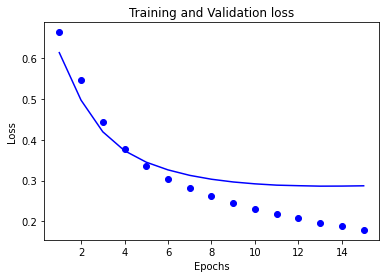

In [43]:
acc = hist['binary_accuracy']
val_acc = hist['val_binary_accuracy']
loss = hist['loss']
val_loss = hist['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

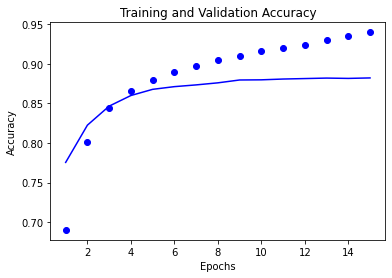

In [42]:
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

We can see that the validation plateuas before the training for both loss and accuracy, this indicates overfitting again. See: https://www.tensorflow.org/tutorials/keras/overfit_and_underfit

## Convert to a raw string model by including the vectorisation layer in the model

In [45]:
raw_string_model = tf.keras.Sequential([
    vectorise_layer,
    model,
    layers.Activation('sigmoid')
])

raw_string_model.compile(
    loss=losses.BinaryCrossentropy(from_logits='False'), optimizer='adam', metrics=['accuracy']
)

loss, accuracy = raw_string_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 82s 104ms/step - loss: 0.5816 - accuracy: 0.8738
0.8737599849700928


In [46]:
examples = ['this movie was amazing, best movie ever ever ever',
            'this movie was fucking awful, why would anyone ver make this piece of rubbish']

raw_string_model.predict(examples)

array([[0.77139705],
       [0.11604765]], dtype=float32)